Notebook to reproduce key results of 'quasi-Monte Carlo graph random features' paper (https://arxiv.org/abs/2305.12470). Using a new QMC scheme that anticorrelates the lengths of random walks on a graph, we can improve the convergence of MC estimators of graph kernels.

In [1]:
import numpy as np
import random as rnd
import time
import matplotlib
from matplotlib import pyplot as plt
from numpy import array, zeros, diag, diagflat, dot
from math import sqrt
import pprint
import scipy
import scipy.linalg
import os
from tqdm import tqdm
from utils import *
from rf_construction import *
import pickle

In [2]:
os.chdir('/homes/ir337/Documents/antithetic_termination_final')
#os.chdir('/your/root/dir/here')

In [3]:
#Parameters
nb_rnd_walks_list = [2,4,8]     #number of walkers to use to estimate kernel
nb_repeats = 100        #number of repeats to get standard deviations
p_halt = 0.5         #probability of a walker halting at a particular timestep
sigma = 0.1   #regulariser

In [4]:
#load adjacency matrix arrays for the graphs to be considered
with open('adjacency_matrices.pkl','rb') as f:
    As = pickle.load(f)

In [5]:
all_graphs_means = [] #holders for the mean approximation error and corresponding standard deviation
all_graphs_stds = []


for graph_id,A in enumerate(As):
    print('Doing graph %s of %s'%(graph_id+1, len(As)))
    
    nb_vertices = len(A)    #size of the graph
    L_tilde = get_laplacian_matrix(A)  #see Eq. 24
    U = - sigma**2 / (1+sigma**2) * (L_tilde - np.eye(len(A)))  #see Eq. 26
    M = np.eye(nb_vertices) + sigma**2 * L_tilde
    groundtruth_matrix = np.linalg.inv(M @ M)  #see Eq. 25

    adj_lists, weight_lists = adj_matrix_to_lists(U)  #get lists of neighbours and weights for each edge

    mean_fro_superlist = []  #to hold all the mean Frob norm errors  
    std_fro_superlist = []  #to hold their respctive standard devs

    
    #iid walkers
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling = None)  #create low rank factorisation
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)  #compute product of random features to approximate Gram matrix
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)    #compute the relative Frob norm between the true and approximated Gram matrices
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    #antithetic termination -- repeat the above with our new QMC scheme
    mean_fro_list = []
    std_fro_list = []
    for index in range(len(nb_rnd_walks_list)):
      print("Number of random walks is: ", nb_rnd_walks_list[index])
      nb_random_walks = nb_rnd_walks_list[index]
      mean_fro = 0
      sum_squares = 0
      for _ in tqdm(range(nb_repeats)):
        A_matrix, B_matrix = create_lr_fact_of_squared_inv_id_min_w(adj_lists,weight_lists,
                                                              p_halt,
                                                              nb_random_walks,term_coupling='antithetic')
        approximate_matrix = np.matmul(A_matrix, B_matrix) / ((1 + sigma**2)**2)
        current_fro = compute_fro(groundtruth_matrix, approximate_matrix,
                                  relative=True)
        mean_fro += current_fro
        sum_squares += current_fro * current_fro
      mean_fro /= nb_repeats
      std_fro = np.sqrt(sum_squares / nb_repeats - mean_fro * mean_fro)
      mean_fro_list.append(mean_fro)
      std_fro_list.append(std_fro)
    mean_fro_superlist.append(mean_fro_list)
    std_fro_superlist.append(std_fro_list)

    all_graphs_means.append(mean_fro_superlist)
    all_graphs_stds.append(std_fro_superlist)
    print('')



Doing graph 1 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 7984.28it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 5509.76it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 3505.92it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 2698.29it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1468.58it/s]


Number of random walks is:  8


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 762.36it/s]



Doing graph 2 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 534.33it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 569.31it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 443.92it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 426.48it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 258.01it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 134.91it/s]



Doing graph 3 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 422.31it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 601.14it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 399.32it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 251.95it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 207.48it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 106.79it/s]



Doing graph 4 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 431.77it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 751.13it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 546.60it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 398.12it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 250.23it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 146.28it/s]



Doing graph 5 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 4541.90it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 2436.01it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 1603.12it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1395.70it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 960.83it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 517.39it/s]



Doing graph 6 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 1495.96it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 1201.14it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 526.91it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 683.84it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 382.00it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 222.65it/s]



Doing graph 7 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 884.41it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 688.30it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:00<00:00, 438.25it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:00<00:00, 326.02it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:00<00:00, 205.74it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:01<00:00, 96.20it/s]



Doing graph 8 of 8
Number of random walks is:  2


100%|██████████| 100/100 [00:03<00:00, 31.11it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:03<00:00, 27.63it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:04<00:00, 23.15it/s]


Number of random walks is:  2


100%|██████████| 100/100 [00:04<00:00, 21.54it/s]


Number of random walks is:  4


100%|██████████| 100/100 [00:06<00:00, 14.80it/s]


Number of random walks is:  8


100%|██████████| 100/100 [00:09<00:00, 10.06it/s]

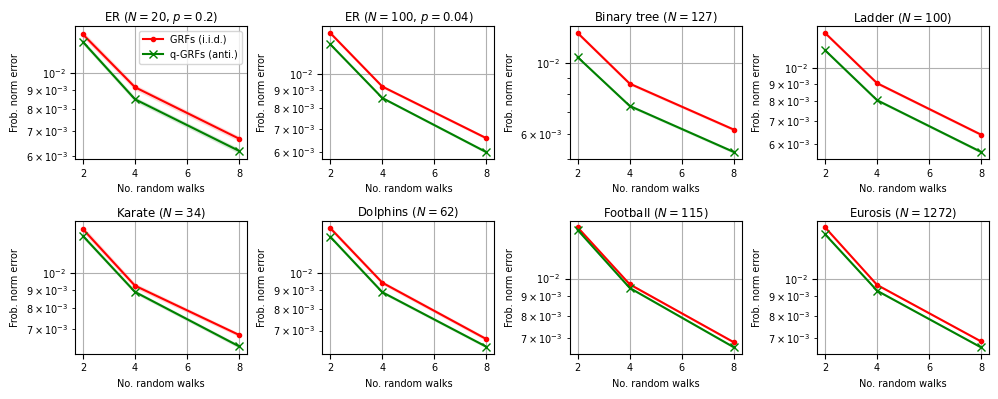

In [6]:
#Doing all the plots

colors = ['red','green']
markers=['.','x']
labels = ['GRFs (i.i.d.)', 'q-GRFs (anti.)']
plt.rcParams.update({'font.size': 7})

fig, ((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(10,4))

titles = ['ER ($N=20$, $p=0.2$)' ,'ER ($N=100$, $p=0.04$)', 'Binary tree ($N=127$)', 'Ladder ($N=100$)','Karate ($N=34$)','Dolphins ($N=62$)','Football ($N=115$)','Eurosis ($N=1272$)' ]
for graph_id in range(8):
    this_graph_means = all_graphs_means[graph_id]
    this_graph_stds = all_graphs_stds[graph_id]

    plt.subplot(2,4,graph_id+1)
    
    for ind in range(2):
      meanst = np.array(this_graph_means[ind])
      sdt = np.asarray(this_graph_stds[ind]) / np.sqrt(nb_repeats)
      plt.yscale('log')

      
      plt.plot(nb_rnd_walks_list, meanst, color = colors[ind], marker = markers[ind], label = labels[ind])
      plt.fill_between(nb_rnd_walks_list, meanst-sdt, meanst+sdt, color = colors[ind],alpha=0.1)

      if graph_id == 0:
         plt.legend()

    plt.title(titles[graph_id],pad=2)
    plt.grid()
    plt.ylabel('Frob. norm error')
    plt.xlabel('No. random walks')

plt.tight_layout()